In [1]:
%cd ..

c:\Users\justi\coding\Uni\MA


In [2]:
import glob
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Plot Classification Errors and Fitness

Single Onset Experiments

In [7]:
run_number = 0
error_file = f"./experiments/ground_truth_scan/10k_baseline_errors.pkl"
fitness_file = f"./experiments/ground_truth_scan/10k_baseline_fitnesses.pkl"

In [8]:
with open(error_file, "rb") as fp:
    errors = pickle.load(fp)
with open(fitness_file, "rb") as fp:
    fitnesses = pickle.load(fp) 

# Parse errors into types
errors_padded = []
max_len = max([len(run) for run in errors])
for run in errors:
    while len(run) < max_len:
        run.append((0, 0, 0))
    errors_padded.append(run)
j_i_runs = [[tup[0] for tup in run] for run in errors_padded]
j_p_runs = [[tup[1] for tup in run] for run in errors_padded]
j_ip_runs = [[tup[2] for tup in run] for run in errors_padded]
j_i_means = np.mean(j_i_runs, axis=0)
j_p_means = np.mean(j_p_runs, axis=0)
j_ip_means = np.mean(j_ip_runs, axis=0)
j_i_means.shape

(10000,)

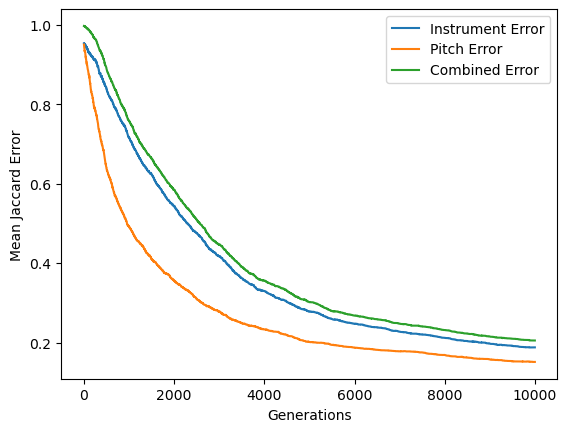

In [9]:
plt.plot(j_i_means, label="Instrument Error")
plt.plot(j_p_means, label="Pitch Error")
plt.plot(j_ip_means, label="Combined Error")
plt.xlabel("Generations")
plt.ylabel("Mean Jaccard Error")
plt.legend()

Multi-Onsets Experiments (Full Piece)

<Axes: xlabel='Generation', ylabel='Mean Jaccard Error'>

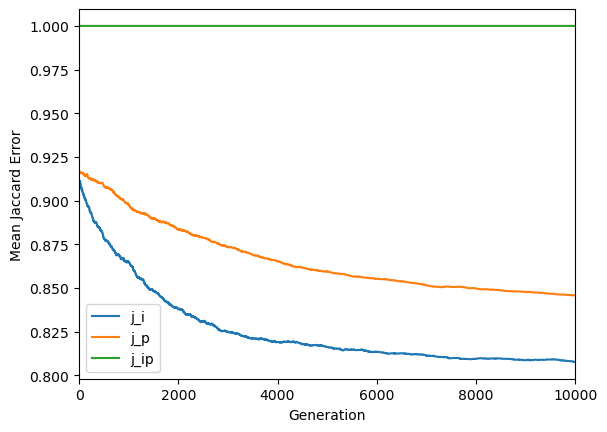

In [16]:
experiment_name = "tiny_aam/300_1_10000_0.05_5_10_1_20_0.9954_15_10_1sec_convlog"
root_path = f"./experiments/{experiment_name}/"
csv_files = glob.glob(root_path + "**/*.csv", recursive=True)
j_i, j_p, j_ip, fitness = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    j_i = pd.concat([j_i, df["j_i"]], axis=1)
    j_p = pd.concat([j_p, df["j_p"]], axis=1)
    j_ip = pd.concat([j_ip, df["j_ip"]], axis=1)
    fitness = pd.concat([fitness, df["fitness"]], axis=1)
df = pd.DataFrame({"j_i":list(j_i.mean(axis=1)), "j_p":list(j_p.mean(axis=1)), "j_ip":list(j_ip.mean(axis=1))})
df_fit = fitness.mean(axis=1)
df.plot(xlabel="Generation", ylabel="Mean Jaccard Error", xlim=(0, 10000))

<Axes: xlabel='Generations', ylabel='Mean Fitness'>

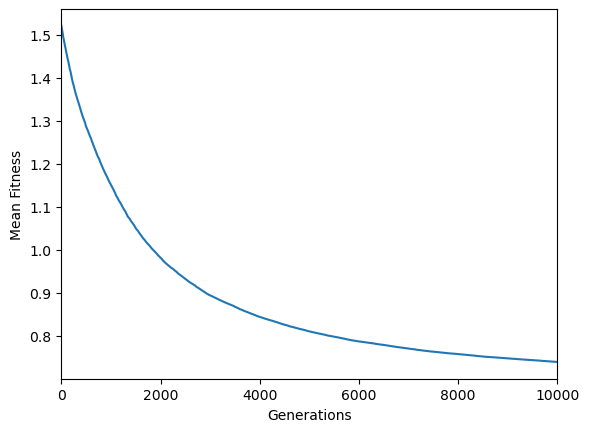

In [15]:
df_fit.plot(xlabel="Generations", ylabel="Mean Fitness", xlim=(0, 10000))

### Plotting extracted pitch probabilities

In [4]:
import librosa
from evoaudio.individual import BaseIndividual
from evoaudio.sample_library import SampleLibrary
from evoaudio.pitch import Pitch

In [5]:
lib = SampleLibrary()

Loading samples: 100%|██████████| 6826/6826 [00:13<00:00, 503.83it/s]


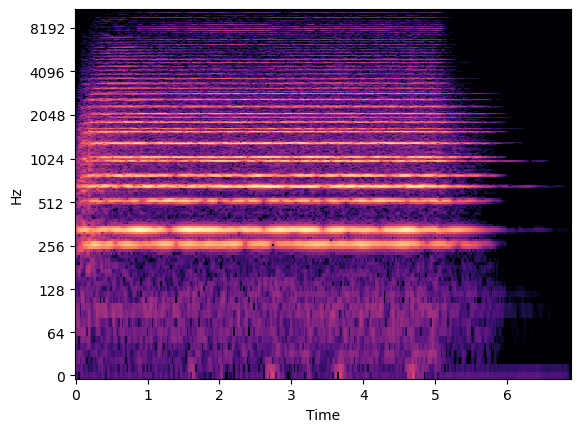

In [20]:
sr = 22050
targets = [("Trumpet", Pitch.c4), ("Trombone", Pitch.e4)]
ind = BaseIndividual()
ind.samples = [lib.get_sample(instrument=tup[0], pitch=tup[1]) for tup in targets]
mix = ind.to_mixdown()
D = librosa.amplitude_to_db(np.abs(librosa.stft(mix)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time',
                               sr=sr)

C:\Users\justi\AppData\Local\Temp\ipykernel_10684\3825791389.py:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note',


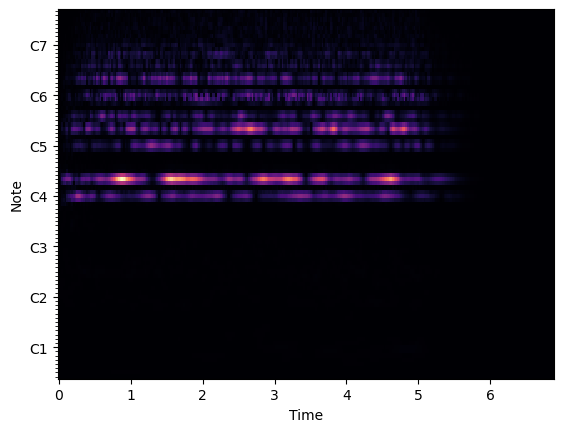

In [21]:
bins_per_octave = 12
fmin = librosa.note_to_hz("f0")
cqt = librosa.cqt(mix, sr=sr, n_bins=88, bins_per_octave=bins_per_octave, fmin=fmin)
log_cqt = librosa.amplitude_to_db(np.abs(cqt))
librosa.display.specshow(cqt, sr=sr, x_axis='time', y_axis='cqt_note', 
                         bins_per_octave=bins_per_octave, fmin=fmin)

In [33]:
np.max(np.abs(cqt))

2.162541

<BarContainer object of 89 artists>

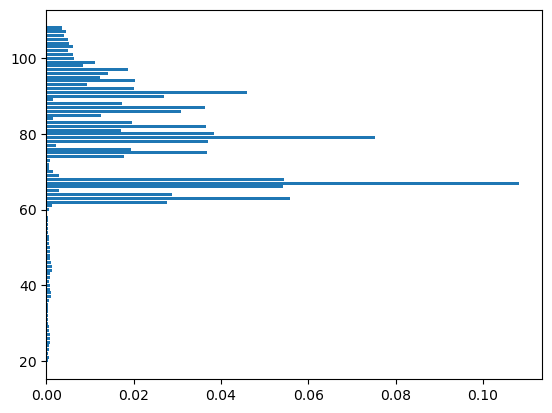

In [36]:
def extract_pitch_probabilities(y, sr=22050, n_bins=89, bins_per_octave=12, fmin=librosa.note_to_hz("f0")):
    """Estimates the pitches in the given signal y and turns
    these estimations into a probability distribution.

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    sr : int, optional
        Sample rate, by default 22050
    n_bins : int, optional
        Number of bins to return, 
        Passed to librosa.cqt, by default 89
    bins_per_octave : int, optional
        Passed to librosa.cqt, by default 12
    fmin : float, optional
        Minimum frequency for librosa.cqt, by default librosa.note_to_hz("f0")

    Returns
    -------
    np.ndarray
        A probability distribution across the 89 pitches we are working with.
    """
    cqt = librosa.cqt(y=y, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave, fmin=fmin)
    #log_cqt = librosa.amplitude_to_db(np.abs(cqt))
    abs_cqt = np.abs(cqt)
    clipped_cqt = np.clip(abs_cqt, a_min=0, a_max=None)
    # clipped_cqt[clipped_cqt < 0.5] = 0
    cqt_sum = np.sum(clipped_cqt, axis=1)
    sum_norm = cqt_sum / np.sum(cqt_sum)
    return np.nan_to_num(sum_norm)

pitches = extract_pitch_probabilities(y=mix)
plt.barh(np.arange(20, 20 + len(pitches)), pitches, )